In [1]:
import pandas as pd
from itertools import *
from more_itertools import *
from collections import OrderedDict, Counter
from functools import lru_cache
from pyvis.network import Network

# colors from https://en.wikipedia.org/wiki/Help:Distinguishable_colors
colors = ["#F0A3FF", "#0075DC", "#993F00", "#4C005C", "#191919", "#005C31", "#2BCE48", "#FFCC99", "#808080", "#94FFB5", "#8F7C00", "#9DCC00", "#C20088", "#003380", "#FFA405", "#FFA8BB", "#426600", "#FF0010", "#5EF1F2", "#00998F", "#E0FF66", "#740AFF", "#990000", "#FFFF80", "#FFFF00", "#FF5005"]
color_names = ["Amethyst", "Blue", "Caramel", "Damson", "Ebony", "Forest", "Green", "Honeydew", "Iron", "Jade", "Khaki", "Lime", "Mallow", "Navy", "Orpiment", "Pink", "Quagmire", "Red", "Sky", "Turquoise", "Uranium", "Violet", "Wine", "Xanthin", "Yellow", "Zinnia"]

# convenience functions to "prettify" and "uglify" nodes
P = lambda seq: ''.join(map(str, ("X" if e is None else e for e in seq)))
U = lambda seq: list(map(int, filter(str.isnumeric, seq)))

# yields every rotation of seq, ie [(1,2,3),(2,3,1),(3,1,2)]
def rotations(seq, n=None):
    if n is None:
        n=len(seq)
    rots = windowed(cycle(seq), n)
    return islice(rots, n)

In [2]:
# all known optimal superpermutations
SPSTR = [[], ['1'], ['121'], ['123121321'], ['123412314231243121342132413214321'], '''123451234152341253412354123145231425314235142315423124531243512431524312543121345213425134215342135421324513241532413524132541321453214352143251432154321
123451234152341253412354123145231425314235142315423124531243512431524312543121354213524135214352134521325413251432513425132451321543215342153241532145321
123451234152341253412354123145231425314235142315421352413521435213452135421534215432154231245321453241532451325413251432513425132453124351243152431254312
123451234152341253412354123145213425134215342135421345214352145321452314253142351423154231245312435124315243125432154325143254132451324153241352413254312
123451234152341253412354132541352413542134521342513421534213541231452314253142351423154231245321435214325143215432145324153245132453124351243152431254312
123451234152341253412354132514325134251324513254135241354213541231452134521435214532154321534215324153214523142531423514231542312453124351243152431254312
123451324513425134521354213524135214352134512341523412534123541231452314253142351423154231245312435124315243125432153421532415321453215432514325413254312
123451324153241352413254132451342513452134512341523412534123541231452314253142351423154213542153421543214532143521432514321542312453124351243152431254312'''.split()]

# convert to zero-based number arrays
SP = [[tuple(int(c)-1 for c in sp) for sp in a] for a in SPSTR]

In [3]:
# class for encoding and decoding using the move-to-back transform
# based on https://en.wikipedia.org/wiki/Move-to-front_transform
class Mtb:
    @staticmethod
    def encode(seq, d=None, output_state=False):
        if d is None:
            d = list(OrderedDict.fromkeys(seq))
        for e in seq:
            rank = d.index(e)
            d.append(d.pop(rank))
            yield tuple(d) if output_state else rank
    @staticmethod
    def decode(enc, n, d=None, output_state=False):
        if d is None:
            d = list(range(n))
        for rank in enc:
            d.append(d.pop(rank))
            yield tuple(d) if output_state else d[-1]
    @staticmethod
    def twist(d, r):
        # "same" as d.append(d.pop(rank))
        return d[:r] + d[r+1:] + d[r:r+1]
    @staticmethod
    def twist_cycle(d, r):
        start = list(d)
        d = list(d)
        yield tuple(d)
        d.append(d.pop(r))
        while d!=start:
            yield tuple(d)
            d.append(d.pop(r))
    @staticmethod
    def untwist(a, b, default=None):
        a = tuple(a)
        b = tuple(b)
        for w in range(len(a)):
            if Mtb.twist(a, w)==b:
                return w
        return default
    @staticmethod
    def all_twist_cycles(n, r):
        elems = set(range(n))
        for prefix in combinations(elems, r):
            mid, *postfix = sorted(elems - set(prefix))
            for pre in permutations(prefix):
                for post in permutations(postfix):
                    yield (pre + rot for rot in rotations((mid, *post)))

In [4]:
# class to explore some of the features of the Mtb encoder
class MtbAtom:
    @staticmethod
    @lru_cache()
    def from_perm(perm):
        perm = tuple(perm)
        zero = tuple(sorted(perm))
        o = 0
        n = len(perm)
        for i in range(n + 1):
            if zero[i-n:]==perm[:n-i]:
                o=n - i
                break
        ret = tuple(Mtb.encode(zero + perm[o:]))[len(zero):]
        return ret
    @staticmethod
    @lru_cache()
    def to_perm(atom, n):
        return tuple(Mtb.decode(chain(repeat(0, n), atom), n))[-n:]
    @staticmethod
    @lru_cache()
    def mul(a, b, n):
        concat = Mtb.decode(chain(repeat(0, n), a, b), n)
        perm = tuple(concat)[-n:]
        return MtbAtom.from_perm(perm)
    @staticmethod
    def all_atoms(n):
        return map(MtbAtom.from_perm, permutations(range(n)))
    @staticmethod
    @lru_cache()
    def cayley_table(n):
        return {(a,b): MtbAtom.mul(a,b,n) for a, b in product(MtbAtom.all_atoms(n), repeat=2)}
    @staticmethod
    def check_associativity(n):
        # warning: SLOW --- O((n!)^3)
        m = MtbAtom.cayley_table(n)
        for a, b, c in product(permutations(MtbAtom.all_atoms(n)), repeat=3):
            if m[m[a,b],c]!=m[a,m[b,c]]:
                return False
        return True
    @staticmethod
    def is_abelian(n):
        m = MtbAtom.cayley_table(n)
        return all(m[a,b]==m[b,a] for (a, b) in combinations(MtbAtom.all_atoms(n), 2))
    @staticmethod
    def simplify(atom, n):
        concat = Mtb.decode(chain(repeat(0, n), atom), n)
        perm = tuple(concat)[-n:]
        return MtbAtom.from_perm(perm)
    @staticmethod
    def order(atom, n):
        return sum(1 for _ in MtbAtom.cyclic_subgroup(atom, n))
        order = 1
        prod = MtbAtom.simplify(atom, n)
        while prod and order<=n:
            prod = MtbAtom.mul(prod, atom, n)
            order += 1
        return order if order<=n else float('inf')
    @staticmethod
    def group_order(n):
        # should always be n! but let's check to be sure
        return len(set(MtbAtom.all_atoms(n)))
    @staticmethod
    def cayley_dataframe(n, diagonalize=False, sep=""):
        # prettier to look at than the dict version
        atoms = sorted(MtbAtom.all_atoms(n), key=lambda a: (len(a), a))
        P = lambda seq: sep.join(map(str, seq)) if seq else "∅"
        if sep is None:
            P = lambda x: x
        data = (tuple(P(MtbAtom.mul(a, b, n)) for b in atoms) for a in atoms)
        if diagonalize:
            data = sorted(data, key=lambda s: s.index("∅"))
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        return pd.DataFrame.from_records(data)
    @staticmethod
    def cyclic_subgroup(atom, n):
        seen=set()
        atom = MtbAtom.simplify(atom, n)
        c = 0
        yield atom
        prod = MtbAtom.mul(atom, atom, n)
        while atom!=prod and c < n:
            yield prod
            if prod in seen:
                raise ValueError("atom has order ∞")
            seen.add(prod)
            prod = MtbAtom.mul(prod, atom, n)

In [5]:
# examples
class Ex:
    @staticmethod
    def print_internal_state_transitions(seq):
        # prints state next to the last n elements of the seq
        seq = tuple(seq)
        n = len(set(seq))
        ranks = Mtb.encode(seq)
        states = Mtb.encode(seq, output_state=True)
        slide_in = chain(repeat("X", n - 1), seq)
        last_n = windowed(slide_in, n)
        # ANSI color codes
        red = "\033[31m"
        blk = "\033[39m"
        for state, out, rank in zip(states, last_n, ranks):
            #  highlight when internal state differs from output
            is_diff = red if state!=out else blk
            #  highlight when output is not a permutation
            is_perm = blk if all_unique(out) and "X" not in out else red
            print(blk, rank, is_diff, P(state), is_perm, P(out))
    # makes an interactive network of state transitions for a Mtb encoder of size n
    # edge thickness and color show the rank of each edge
    # can be passed a list of edges as a "trace", which will weight only those edges and annotate the index
    @staticmethod
    def show_state_transitions(n, trace=[], node_renamer=P, ranks=None, edge_annotations=dict(), node_size=10, color_rank=0):
        net = Network(directed=True, height="800px", width="100%", notebook=True)
        net.options.physics.solver = "forceAtlas2Based"

        # show all ranks by default (up to n-1 to hide self-loops)
        if ranks is None:
            ranks = range(n - 1)

        # color perms in the same color rank cycle the same color
        for color, twist_cycle in zip(cycle(colors), Mtb.all_twist_cycles(n, color_rank)):
            for twist in twist_cycle:
                net.add_node(node_renamer(twist), color=color, size=node_size)

        # add all cycles of the same rank
        edges = dict()
        for rank in (ranks):
            for twist_cycle in Mtb.all_twist_cycles(n, rank):
                for a, b in islice(pairwise(cycle(twist_cycle)), n - rank):
                    edges[a,b] = {
                        "rank": rank,
                        "width": 0.1 if trace else rank,
                        "color": colors[rank],
                        "title": f"{P(a)}→{P(b)} {rank + 1}-cycle",
                        "physics": not trace
                    }

        # annotate the trace
        for i, (a, b) in enumerate(trace):
            if (a, b) not in edges:
                rank=Mtb.untwist(a, b)
                if rank is not None:
                    edges[a,b]={
                        "rank": rank,
                        "color": colors[rank],
                        "title": f"{P(a)}→{P(b)} {rank + 1}-cycle"
                    }
                else:
                    edges[a,b]={"title": ""}
            edges[a, b]["title"]+=f" †{i}"
            edges[a, b]["width"]=6
            edges[a, b]["physics"]=True

        # add any additional edge annotations
        for key, annotation in edge_annotations.items():
            if isinstance(key, int):
                # key is a rank, update all ranks of that type
                for edge, options in tuple(edges.items()):
                    if key==options["rank"]:
                        edges[edge].update(annotation)
            else:
                # key is a specific edge
                edges[key].update(annotation)

        # add the edges to the net
        for (a, b), options in edges.items():
            net.add_edge(node_renamer(a), node_renamer(b), **options)

        # show the net
        net.show_buttons(filter_=["manipulation", "physics"])
        return net.show("states.html")
    @staticmethod
    def show_trace(seq, *args, **kwargs):
        seq = tuple(seq)
        trace = tuple(pairwise(Mtb.encode(seq, output_state=True)))
        opts = {edge: {"length": 100} for edge in trace}
        n = len(set(seq))
        return Ex.show_state_transitions(n, *args, trace=trace, edge_annotations=opts, **kwargs)

In [6]:
P(Mtb.encode(SP[5][6]))

'000000100000100000100010000010000010000010010001000001000001000002100000100000100000100000210000010000010000010001001000001000001000001000100000100000100'

# The Move-To-Back Transform
A common technique used by compression algorithms is called the move-to-front transform. By analogy, it works like a stack of books where each time you reference a book it's index in the stack is noted and it's placed on top. If you have the list of indices and the initial order, it's trivial to recover the reading list.

Move-to-front does work well on superpermutations but ends up pulling from the back of the list every time. Move-to-back is the same algorithm but we put the symbol on the bottom instead of the top of the stack, such that the top of the stack is the element that hasn't appeared for the longest.

As an example, starting with a stack of [0, 1, 2, 3], the encoding for SP4,0 is 000000010000100002100001000010000, which is down the left column below. The middle column is the inner state transistions and the right column is the last 4 elements of the the output.

In [7]:
Ex.print_internal_state_transitions(SP[4][0])

 0  1230  XXX0
 0  2301  XX01
 0  3012  X012
 0  0123  0123
 0  1230  1230
 0  2301  2301
 0  3012  3012
 1  3120  0120
 0  1203  1203
 0  2031  2031
 0  0312  0312
 0  3120  3120
 1  3201  1201
 0  2013  2013
 0  0132  0132
 0  1320  1320
 0  3201  3201
 2  3210  2010
 1  3102  0102
 0  1023  1023
 0  0231  0231
 0  2310  2310
 0  3102  3102
 1  3021  1021
 0  0213  0213
 0  2130  2130
 0  1302  1302
 0  3021  3021
 1  3210  0210
 0  2103  2103
 0  1032  1032
 0  0321  0321
 0  3210  3210


# Building up atomic structures
`MtbAtom.simplify` forms an equivalence class of encodings based on the last encoded permutation, e.g. 00000001000≡0200 because they both decode to a string with '1423' as the final permutation

In that sense, composition of encodings is associative which means an encoded superperm is any encoding where there is a bijection between every "valid" prefix of the encoding and a unique equivalence class.

This lets us pre-prepare "chunks", e.g., 00000 would be the standard 1-cycle chunk for SP5 and 00000100000100000100000 would be the standard 2-cycle chunk for SP5 while 0000010000010000010001000001000001000100000100000100000100100 is an alternate 2-cycle chunk for SP5.

This lets us write all 8 SP5s as follows:

    A=00000100000100000100000
    B=0000010000010000010001001000001000001000001000100000100000100
    C=0010010000010000010000010001000001000001000100000100000100000

    0000A21A21A321A21A21A
    0000A21A21A320A21A21A
    0000A21B21B'
    0000A21C21C'
    0000C'21A21C
    0000B21B'21A
    0000B'21A21B
    0000C21C'21A

Removing the joining twists reveals some basic structure: `AAAAAA`, `AAAAAA`, `ABB'`, `ACC'`, `C'AC`, `BB'A`, `B'AB`, `CC'A`

Printing the cayley table for n=4 looks like the following:

In [8]:
MtbAtom.cayley_dataframe(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,∅,0,00,10,000,010,100,110,200,210,0010,0100,0110,0200,0210,1000,1010,1100,1200,1210,2000,2010,2100,2110
1,0,00,000,010,∅,0010,0100,0110,0200,0210,1100,1210,1200,1000,1010,2110,2100,10,2000,2010,110,100,210,200
2,00,000,∅,0010,0,1100,1210,1200,1000,1010,10,2010,2000,2110,2100,200,210,010,110,100,0110,0100,0210,0200
3,10,100,1000,1010,0110,0100,0210,0200,∅,0010,00,2110,2100,2010,2000,210,200,110,010,000,0,1100,1210,1200
4,000,∅,0,1100,00,10,2010,2000,2110,2100,010,100,110,200,210,0200,0210,0010,0110,0100,1200,1210,1010,1000
5,010,0100,2110,2100,1200,1210,1010,1000,0,1100,000,200,210,100,110,0210,0200,0110,0010,∅,00,10,2010,2000
6,100,1000,0110,0100,10,00,2110,2100,2010,2000,110,000,010,210,200,1200,1210,1010,0,1100,0200,0210,0010,∅
7,110,1100,2010,2000,0200,0210,0010,∅,0110,0100,100,210,200,000,010,1210,1200,0,1010,1000,10,00,2110,2100
8,200,2000,0010,∅,1210,1200,0,1100,1010,1000,210,010,000,110,100,00,10,2010,2110,2100,0210,0200,0110,0100
9,210,2100,1010,1000,0210,0200,0110,0100,0010,∅,200,110,100,010,000,10,00,2110,2010,2000,1210,1200,0,1100


Looking at the nets of the encoder states for a couple of the superpermutations gives a better idea of what's going on:
### SP4,0
`Ex.show_trace(SP[4][0], color_rank=1)`
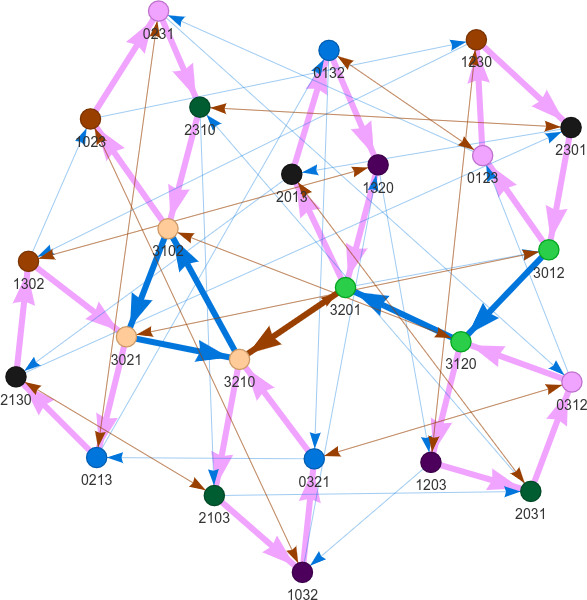

### SP5,0
I've hidden everything but the trace for the rest of the graphs by setting `ranks={}`

`Ex.show_trace(SP[5][0], ranks={}, color_rank=1)`
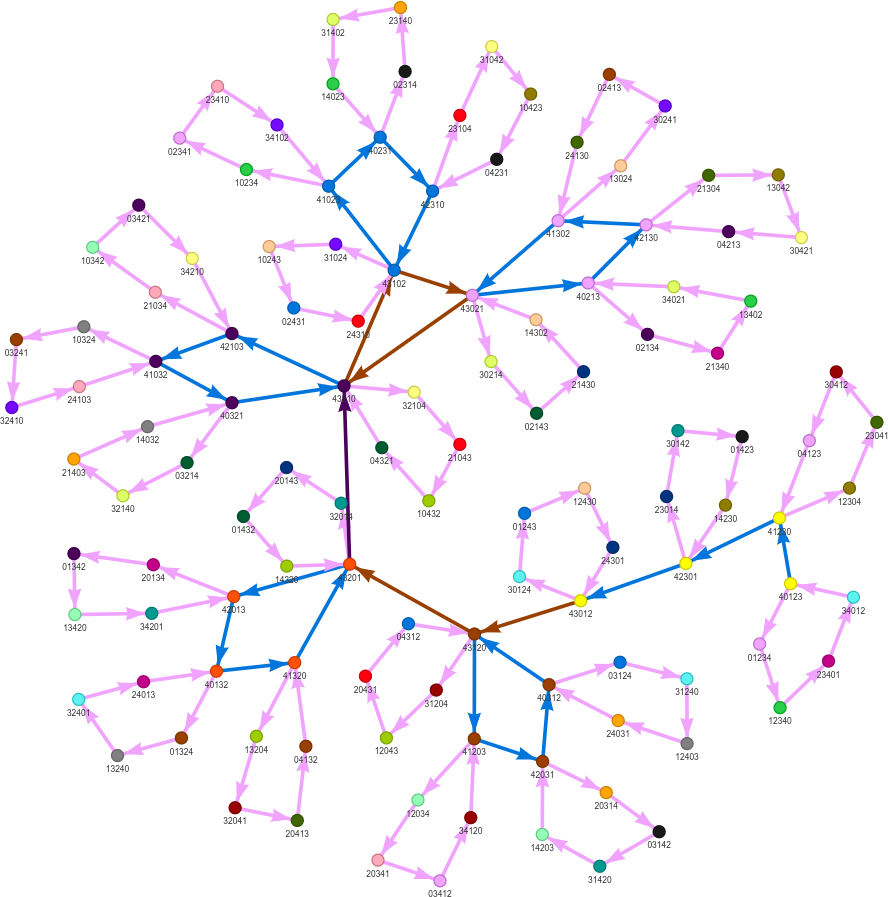
This shows the structure fairly well, and if two edges were drawn at 43201=>43012=>40123 it would form a sort of recursive polygon fractal where starting with a 0D polygon (a point) we replace all the vertices with a polygon one dimension higher, so a point becomes a line, then the vertices of the line are replaced with triangles, the vertices of each triangle is replaced with a square, etc.

The full state space is built up in much the same way (starting at a point and expanding it), except the vertex is "expanded" rather than replaced. SP3,0 shows this more clearly, where the possibility of state transistions are all the edges while the ones used by the encoding are highlighted:
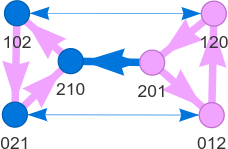

### SP5,2
`Ex.show_trace(SP[5][2], ranks={}, color_rank=1)`
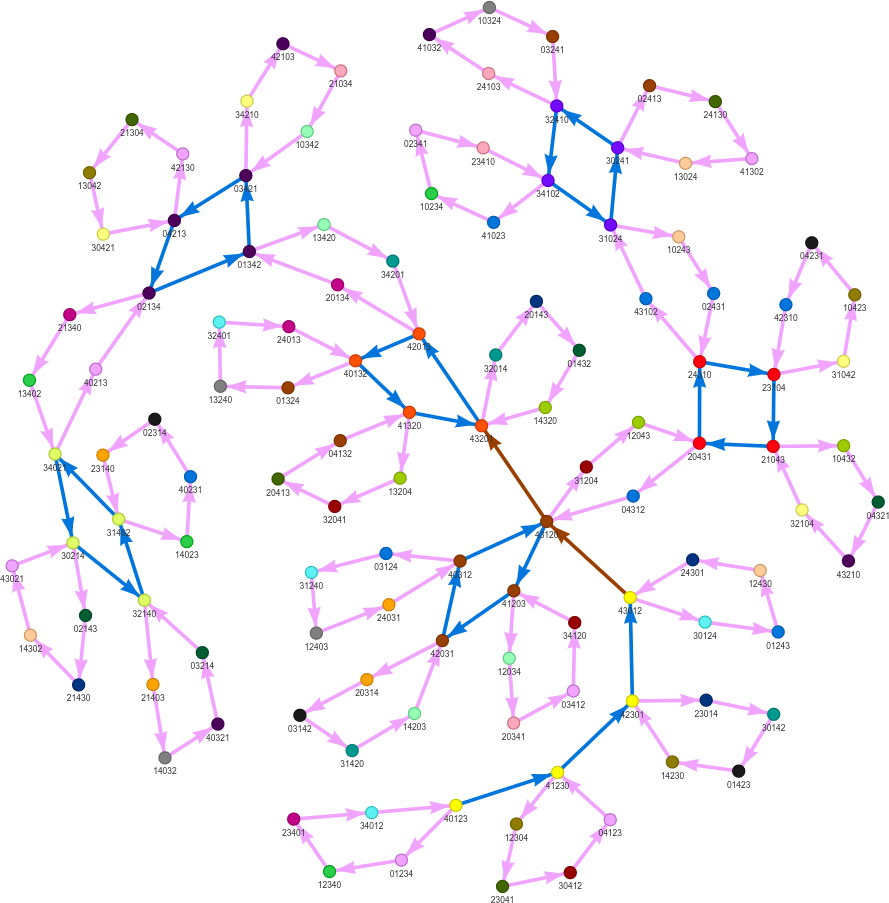
SP5,2 is the first novel superpermutation and it's pretty apparent that fixing the missing edges isn't going to give us the same nice fractal pattern. Instead, we end up with something that looks more like someone chopped up one side of SP4 before replacing the vertices then just glued everything back together:

`Ex.show_trace(SP[4][0], ranks={})`
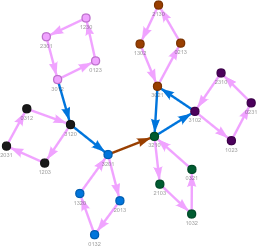
Each 2-cycle "limb" grows out from the "root" 2-cycle and each limb is always completed before returning to the root. Not sure if this holds for higher dimension, but the limbs also don't branch.

It seems like there may be a more general structure here that can tell us how to "peel the orange" of the full state space.

## Interesting observations:
Looking at the net formed by ranks n-2 & n-4 we get a set of n!/4! truncated octahedron:
`Ex.show_state_transitions(5, ranks={1, 3})`
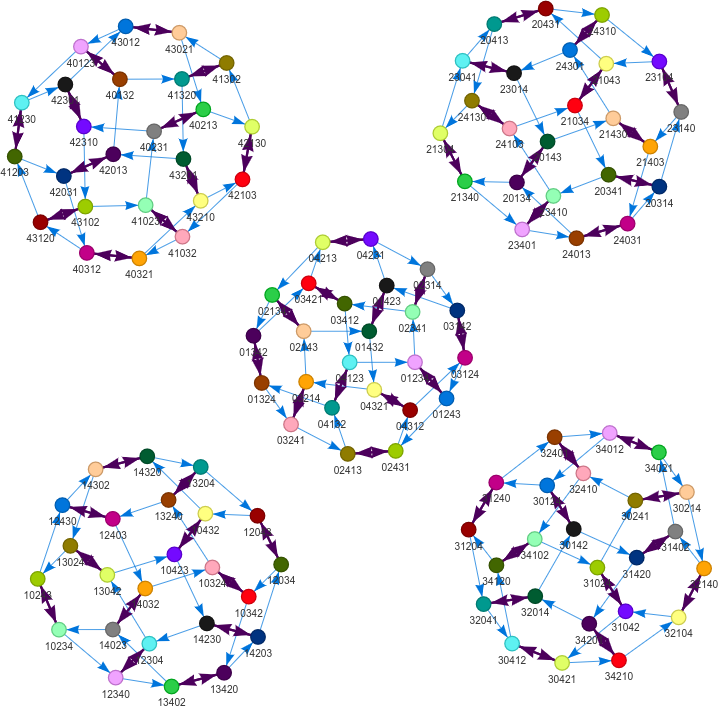

Looking at ranks n-2 & n-3 we get n!/3! prisms:
`Ex.show_state_transitions(4, ranks={1,2})`
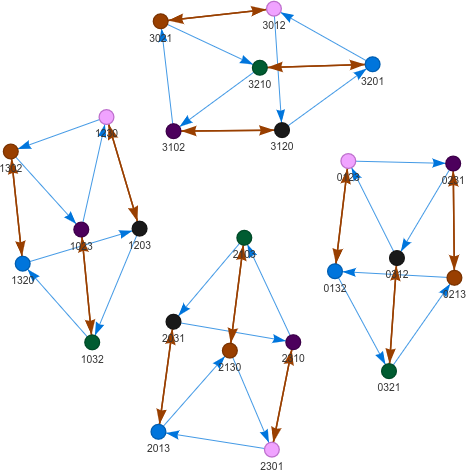

Looking at ranks 0 & 1, the net is always fully connected (which agrees with being able to build cycle covers out of just 1- & 2-cycles). For n=3, we get a prism as above but n=4 give us a nice expanded cube. No clue what n=5 is, but it really upsets the physics solvers for the network drawing library:
`Ex.show_state_transitions(5, ranks={0,1})`
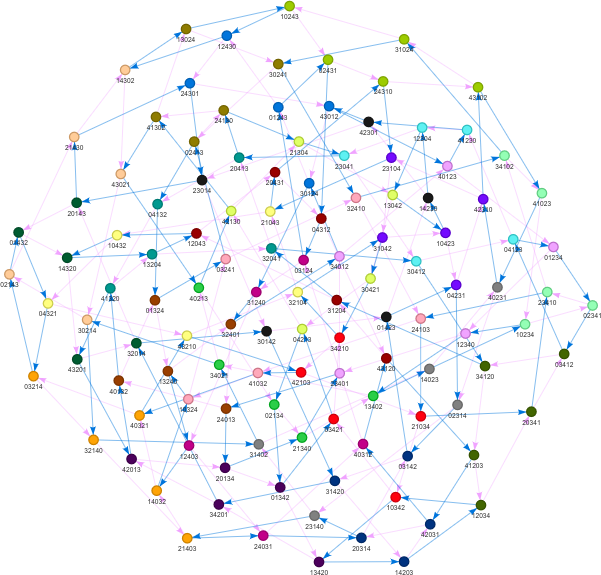

We can also "collapse" the cycles by naming the nodes with their minimal twist form. For example, if we collapse all the rank-0 cycles for n=5, we get a different perspective on the shape of n=2, r={0,1}:
`Ex.show_state_transitions(5, ranks={0,1}, node_renamer=lambda n:P(min(Mtb.twist_cycle(n, 0))))`
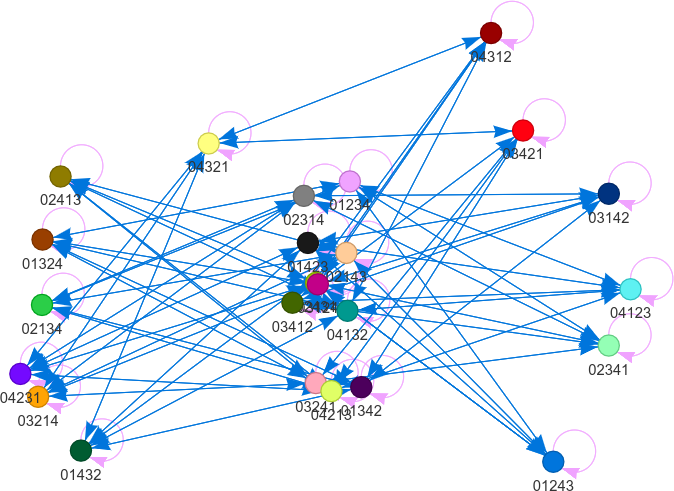

Doing the same but collapsing the rank-1 cycles yields the following:
`Ex.show_state_transitions(5, ranks={0,1}, node_renamer=lambda n:P(min(Mtb.twist_cycle(n, 1))))`
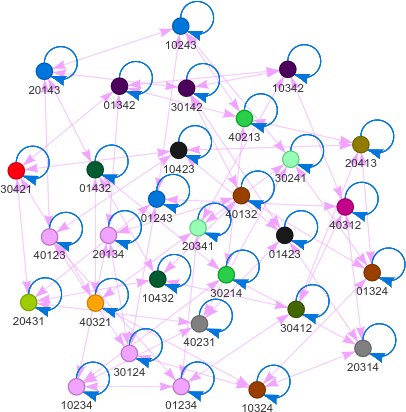